22BAI1173\
27/03/2025\
Lab 10\
L39+L40\
chatgpt:

In [ ]:
import warnings
warnings.filterwarnings('ignore')

# Question 1 - 1.	Super-Resolution using Multi-Resolution Analysis.
•	Generate a low-resolution image by downsampling a high-resolution image.\
•	Use DWT (Discrete Wavelet Transform) and Interpolation to reconstruct a super-resolved image.\
•	Compare the PSNR and SSIM values of different super-resolution methods.


In [5]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 43.9 MB/s eta 0:00:00


In [7]:
import cv2
import numpy as np
import pywt
import matplotlib.pyplot as plt
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

In [25]:
image_path = 'hr_image.jpg'
hr_image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [26]:
def downsample_image(image, scale=2):
    return cv2.resize(image, (image.shape[1] // scale, image.shape[0] // scale), interpolation=cv2.INTER_CUBIC)

In [27]:
lr_image = downsample_image(hr_image, scale=2)

In [28]:
def upsample_image(image, scale=2):
    return cv2.resize(image, (image.shape[1] * scale, image.shape[0] * scale), interpolation=cv2.INTER_CUBIC)

In [29]:
bicubic_sr = upsample_image(lr_image, scale=2)

In [30]:
def dwt_interpolation_sr(lr_image):
    coeffs = pywt.dwt2(lr_image, 'haar')
    cA, (cH, cV, cD) = coeffs

    cA = cv2.resize(cA, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_CUBIC)

    cH = cv2.resize(cH, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_CUBIC)
    cV = cv2.resize(cV, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_CUBIC)
    cD = cv2.resize(cD, (lr_image.shape[1], lr_image.shape[0]), interpolation=cv2.INTER_CUBIC)

    sr_image = pywt.idwt2((cA, (cH, cV, cD)), 'haar')
    return sr_image

In [31]:
dwt_sr = dwt_interpolation_sr(lr_image)

In [32]:
def compute_metrics(original, restored):
    psnr_value = psnr(original, restored, data_range=255)
    ssim_value = ssim(original, restored, data_range=255)
    return psnr_value, ssim_value

In [33]:
bicubic_sr.shape, dwt_sr.shape, hr_image.shape

((756, 1344), (756, 1344), (756, 1344))

In [34]:
bicubic_psnr, bicubic_ssim = compute_metrics(hr_image, bicubic_sr)
dwt_psnr, dwt_ssim = compute_metrics(hr_image, dwt_sr)

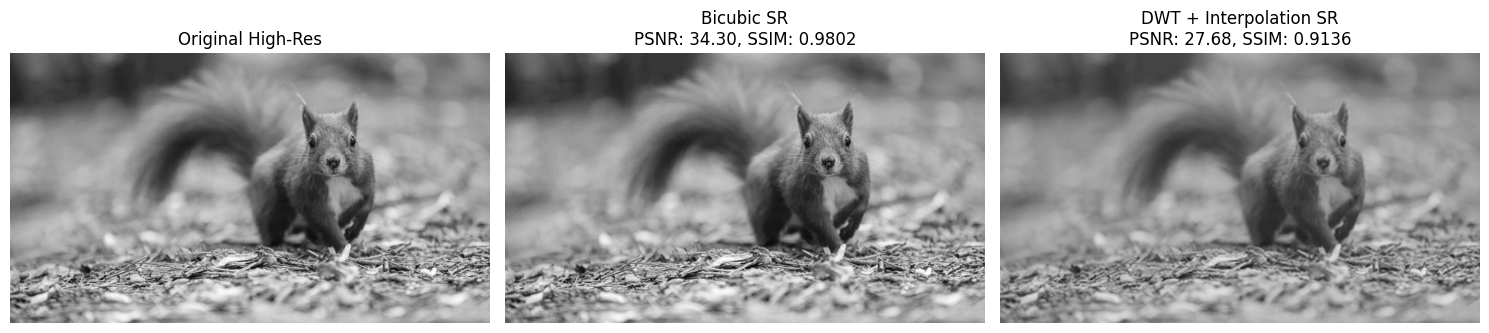

In [35]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
axes[0].imshow(hr_image, cmap='gray')
axes[0].set_title('Original High-Res')
axes[1].imshow(bicubic_sr, cmap='gray')
axes[1].set_title(f'Bicubic SR\nPSNR: {bicubic_psnr:.2f}, SSIM: {bicubic_ssim:.4f}')
axes[2].imshow(dwt_sr, cmap='gray')
axes[2].set_title(f'DWT + Interpolation SR\nPSNR: {dwt_psnr:.2f}, SSIM: {dwt_ssim:.4f}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

# Question 2 - Blurred Image Deblurring using FFT and DCT
•	Simulate motion blur in an image using a Gaussian filter.\
•	Apply FFT-based Wiener filtering to restore the image.\
•	Apply DCT-based deblurring and compare results.\
•	Compute RMSE (Root Mean Square Error) for quality assessment.


In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import mean_squared_error

In [37]:
image_path = 'blurred_image.jpg'
original = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

In [38]:
def apply_gaussian_blur(image, ksize=15, sigma=5):
    return cv2.GaussianBlur(image, (ksize, ksize), sigma)

In [39]:
blurred = apply_gaussian_blur(original)

In [40]:
kernel = cv2.getGaussianKernel(15, 5)
kernel = kernel @ kernel.T

In [41]:
def wiener_filter(img_blur, kernel, K=0.01):
    img_fft = np.fft.fft2(img_blur)
    kernel_fft = np.fft.fft2(kernel, s=img_blur.shape)
    kernel_fft = np.where(kernel_fft == 0, 1e-8, kernel_fft)  # Avoid division by zero
    img_restored = np.fft.ifft2(img_fft * np.conj(kernel_fft) / (np.abs(kernel_fft) ** 2 + K))
    return np.abs(img_restored)

In [42]:
wiener_restored = wiener_filter(blurred, kernel)

In [45]:
def dct_deblurring(img_blur, kernel):
    img_dct = cv2.dct(np.float32(img_blur))

    kernel_dct = cv2.dct(np.float32(kernel))

    kernel_dct_padded = np.zeros_like(img_dct)
    kernel_dct_padded[:kernel_dct.shape[0], :kernel_dct.shape[1]] = kernel_dct

    kernel_dct_padded = np.where(kernel_dct_padded == 0, 1e-8, kernel_dct_padded)

    img_restored = cv2.idct(img_dct / kernel_dct_padded)

    return np.clip(img_restored, 0, 255)

In [46]:
dct_restored = dct_deblurring(blurred, kernel)

In [47]:
def compute_rmse(original, restored):
    return np.sqrt(mean_squared_error(original, restored))

In [48]:
rmse_wiener = compute_rmse(original, wiener_restored)
rmse_dct = compute_rmse(original, dct_restored)

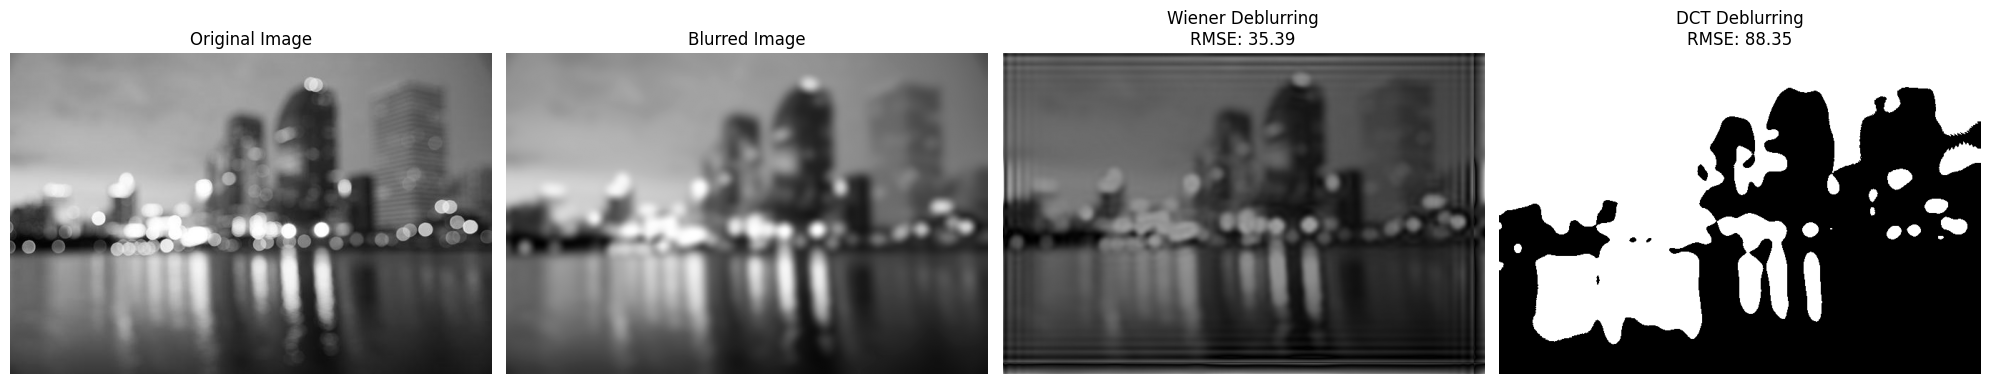

In [49]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(original, cmap='gray')
axes[0].set_title('Original Image')
axes[1].imshow(blurred, cmap='gray')
axes[1].set_title('Blurred Image')
axes[2].imshow(wiener_restored, cmap='gray')
axes[2].set_title(f'Wiener Deblurring\nRMSE: {rmse_wiener:.2f}')
axes[3].imshow(dct_restored, cmap='gray')
axes[3].set_title(f'DCT Deblurring\nRMSE: {rmse_dct:.2f}')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()